In [155]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import operator
from Levenshtein import *
import re
from tabulate import tabulate
import age_gender_predictor
import json
from scipy.stats import spearmanr
from operator import itemgetter
%matplotlib inline


In [85]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

In [258]:
# Data Fetching, transformation and filtering


def getLangRatio(cursor):
    lang_ratios = {}
    for tweet in cursor:
        lang = 1 if tweet["lang"] == "en" else 0
        user_id = tweet["user"]["id"]
        if user_id in lang_ratios:
            lang_ratios[user_id].append(lang)
        else:
            lang_ratios[user_id] = [lang]
    for user_id, ratio in lang_ratios.items():
        lang_ratios[user_id] = np.sum(ratio) / len(ratio)
    return lang_ratios
                                   

def getUsersTweets(dbName,collectionName, en_threshold=0.9):
    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    lang_ratios = getLangRatio(cursor)

    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    usersTweets = {}
    for tweet in cursor:
        userID = tweet["user"]["id"]
        if lang_ratios[userID] < en_threshold:
            continue
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersTweets:
            usersTweets[userID] = {}
        if date not in usersTweets[userID]:
            usersTweets[userID][date] = {}
            
        usersTweets[userID][date]['text'] = text
        usersTweets[userID][date]['polarity'] =  polarity
        usersTweets[userID][date]['emotion'] =  emotion
        usersTweets[userID][date]['emotion_2'] =  emotion_2
        usersTweets[userID][date]['ambiguous'] =  ambiguous
    return usersTweets



def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())


def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=100):    #Spam and inactive user filter
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group




In [259]:
BPD_tweets =  getUsersTweets("patients","BPD_clean")
regular_tweets =  getUsersTweets("idea","regularUser_en_fixed_emotion")
bipolar_tweets = getUsersTweets("patients","bipolar_clean")
mix_tweets = getUsersTweets("patients","bb_mix")



#Transform raw tweets into timeSeries data.
BPDtimeSeries = timeSeriesTransform(BPD_tweets) 
regular_timeSeries = timeSeriesTransform(regular_tweets)
bipolar_timeSeries = timeSeriesTransform(bipolar_tweets)
mix_timeSeries = timeSeriesTransform(mix_tweets)

#Filter and clean the timeSeries data
BPD_clean = userFilter(BPDtimeSeries)
regular_clean = userFilter(regular_timeSeries)
bipolar_clean = userFilter(bipolar_timeSeries)
mix_clean = userFilter(mix_timeSeries)


groups = [regular_clean,bipolar_clean, BPD_clean, mix_clean]
colors=['g','b', 'y','r']
group_names = ["Randpm Samples", "Bipolar", "BPD","Mix"]


In [260]:
#Statistics facts of experimental data

headers = ["Group","Users", "Tweets", "Average tweets"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    tweets_num = sum([timeSeries.shape[0] for timeSeries in group])
    users_num = len(group)
    average_tweets_num = tweets_num / users_num
    contents.append([group_name, users_num, tweets_num, average_tweets_num])
    
print(tabulate(contents, headers=headers))

Group             Users    Tweets    Average tweets
--------------  -------  --------  ----------------
Randpm Samples      548    796957           1454.3
Bipolar             278    347774           1250.99
BPD                 203    225774           1112.19
Mix                  38     54786           1441.74


Group             Male users    Female users    Average age
--------------  ------------  --------------  -------------
Randpm Samples     0.427007         0.572993        25.3958
Bipolar            0.165468         0.834532        34.3404
BPD                0.0985222        0.901478        31.1676
Mix                0.105263         0.894737        33.3053


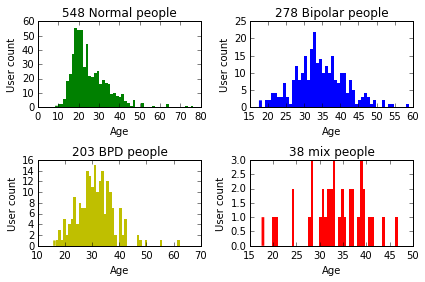

In [261]:
#Age and gender Distribution
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)


def userValueDistribution(groups, x_name ,  method, legends, colors, bins=50):
    _, plot_axis = plt.subplots(2, 2)
    plot_sequence = ((0,0),(0,1),(1,0),(1,1))
    for g,group in enumerate(groups):
        
        values = [method(timeSeries) for timeSeries in group]
          
        
        plot_axis[plot_sequence[g]].hist(values ,color=colors[g], bins = bins, edgecolor='none' )
        plot_axis[plot_sequence[g]].set_ylabel('User count')
        plot_axis[plot_sequence[g]].set_xlabel(x_name)
        plot_axis[plot_sequence[g]].set_title(str(len(group)) + " " + legends[g] + " people")

        #print("Total People: {} std:".format(len(group)))
        #print("{0} mean :{1:2f} STD:{2:2f}".format(x_name ,np.mean(values),np.std(values)))
    plt.tight_layout()
    plt.show()
    


headers = ["Group","Male users", "Female users", "Average age"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    users_num = len(group)
    users_gender = [getGender(timeSeries) for timeSeries in group]
    users_age = [getAge(timeSeries) for timeSeries in group]
    male_ratio = len([gender for gender in users_gender if gender < 0]) / users_num
    female_ratio = 1 - male_ratio
    average_age = sum(users_age) / users_num
    contents.append([group_name, male_ratio, female_ratio, average_age])
print(tabulate(contents, headers=headers))



userValueDistribution(groups,"Age", getAge, legends, colors)



In [285]:
#Show the LIWC correlations 
def loads_LIWC():
    f = open("../4_prediction_visualization/categories.json", 'r')
    categories = json.load(f)
    f = open("../4_prediction_visualization/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                   
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories
LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC() 

def getLIWC_user(timeSeries):
 
    LIWC_counts = {}
    
 
    features = np.zeros(len(LIWC_categories),dtype=int)
    
    texts= timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break


            for category_index in category_indices:

                category_name = LIWC_categories[category_index]

                LIWC_counts[category_name] = LIWC_counts.get(category_name,0) + 1

    for category_name in LIWC_counts:
        LIWC_counts[category_name] /= timeSeries.shape[0]
    
    return LIWC_counts

def getLIWC_group(group):
    LIWC_counts = {}
    users_num = len(group)
    for category in LIWC_categories.values():
        LIWC_counts[category] = []
    for timeSeries in group:
        user_LIWC_count = getLIWC_counts(timeSeries)
      
        for category in LIWC_categories.values():
          
            LIWC_counts[category].append(user_LIWC_count.get(category,0))
            
    
    
    return LIWC_counts
        


def summaryTable(groups,names, method, style="default", tablefmt = "plain"):
    header = ["category"]
    group_counts = []
    base = method(groups[0])
    base_labels = [0] * len(groups[0])
    contents = []
    for name in names[1:]:
        header.append(name + " C")
        header.append(name + " P")
        
        
    for group in groups[1:]:
        group_counts.append(method(group))
        
        
        
    if style == "default":
        for category, base_count in base.items():
            content = [category]
            for g,group in enumerate(groups[1:]):


                labels = base_labels + ([1]*len(group))
                counts = base_count + group_counts[g][category]

                c, p = spearmanr(labels, counts)

                content.append(c)
                content.append(p)


            contents.append(content)
        
  
        contents = sorted(contents, key=lambda pair: abs(pair[1]), reverse=True)
    
    
    
    elif style == "LIWC":
        categories_order = [('funct',1), ('pronoun',2), ('ppron',3), ('i',4), ('we',4), ('you',4), ('shehe',4),
 ('they',4), ('ipron',3), ('article',2), ('verb',1), ('auxverb',2), ('past',2), ('present',2), ('future',2), ('adverb',2),
 ('preps',2), ('conj',2), ('negate',2), ('quant',2), ('number',2), ('swear',1), ('social',1), ('family',2), ('friend',2),
 ('humans',2), ('affect',1), ('posemo',2), ('negemo',2), ('anx',3), ('anger',3), ('sad',3), ('cogmech',1), ('insight',2),
 ('cause',2), ('discrep',2), ('tentat',2), ('certain',2), ('inhib',2), ('incl',2), ('excl',2), ('percept',1), ('see',2),
 ('hear',2), ('feel',2), ('bio',1), ('body',2), ('health',2), ('sexual',2), ('ingest',2), ('relativ',1), ('motion',2),
 ('space',2), ('time',2), ('work',1), ('achieve',1), ('leisure',1), ('home',1), ('money',1), ('relig',1), ('death',1), 
('assent',1), ('nonfl',1), ('filler',1)]
        for category, indent_num in categories_order:
            content = [ "_." * (indent_num-1) + category]
            base_count = base[category]
            for g,group in enumerate(groups[1:]):
                
                
                labels = base_labels + ([1]*len(group))
                counts = base_count + group_counts[g][category]

                c, p = spearmanr(labels, counts)

                content.append(c)
                content.append("{}%".format(int(p*100)))
            contents.append(content)


            
            

        
    print(tabulate(contents, headers=header,floatfmt=".2f", tablefmt=tablefmt))
    #return contents
    



summaryTable(groups, group_names,getLIWC_group, style="LIWC", tablefmt="fancy_grid")
print("\n====================\n Bipolar versus BPD \n")
summaryTable([bipolar_clean, BPD_clean],["bipolar", "BPD"],getLIWC_group)


╒═════════════╤═════════════╤═════════════╤═════════╤═════════╤═════════╤═════════╕
│ category    │   Bipolar C │ Bipolar P   │   BPD C │ BPD P   │   Mix C │ Mix P   │
╞═════════════╪═════════════╪═════════════╪═════════╪═════════╪═════════╪═════════╡
│ funct       │        0.38 │ 0%          │    0.39 │ 0%      │    0.19 │ 0%      │
├─────────────┼─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ _.pronoun   │        0.25 │ 0%          │    0.32 │ 0%      │    0.14 │ 0%      │
├─────────────┼─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ _._.ppron   │        0.15 │ 0%          │    0.23 │ 0%      │    0.09 │ 2%      │
├─────────────┼─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ _._._.i     │        0.20 │ 0%          │    0.34 │ 0%      │    0.15 │ 0%      │
├─────────────┼─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ _._._.we    │        0.00 │ 88%         │   -0.12 │ 0%      │   -0.04 │ 30

In [287]:
#Polarity Correlation

def getFlipsCount(timeSeries, upperbound=60, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips


def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / total_tweets


def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / total_tweets





def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        tweets_length = timeSeries.shape[0]
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity





summaryTable(groups, group_names, getPolarity)



headers = ["Group","Positive Ratio Mean","Positive Ratio STD", "Negative Ratio Mean", "Negative Ratio STD"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratios = [getPositiveRatio(timeSeries) for timeSeries in group]
    negative_ratios = [getNegativeRatio(timeSeries) for timeSeries in group]
    positive_ratio_mean = np.mean(positive_ratios)
    negative_ratio_mean = np.mean(negative_ratios)
    positive_ratio_std = np.std(positive_ratios)
    negative_ratio_std = np.std(negative_ratios)

    contents.append([group_name, positive_ratio_mean, positive_ratio_std, negative_ratio_mean, negative_ratio_std])
print("\n=========\n")
print(tabulate(contents, headers=headers))
        
        

category           Bipolar C    Bipolar P    BPD C    BPD P    Mix C    Mix P
flips                   0.37         0.00     0.53     0.00     0.25     0.00
negative_combos         0.23         0.00     0.44     0.00     0.22     0.00
negative_ratio          0.19         0.00     0.43     0.00     0.19     0.00
positive_ratio          0.15         0.00     0.11     0.00     0.06     0.16
positive_combos         0.14         0.00     0.09     0.01     0.07     0.09


Group             Positive Ratio Mean    Positive Ratio STD    Negative Ratio Mean    Negative Ratio STD
--------------  ---------------------  --------------------  ---------------------  --------------------
Randpm Samples               0.223576             0.13237                 0.130068             0.0618849
Bipolar                      0.250742             0.115161                0.172117             0.0967615
BPD                          0.243835             0.11811                 0.217929             0.0947692
Mix  

In [310]:
#Emotions Table


def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / filtered_emotions.shape[0]
    return emotions_count
        


def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts


emotions = ["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]

headers = ["Group"] + emotions
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    emotions_counts = getGroupEmotions(group)
    for emotion in emotions:
        emotion_ratio = "{}%".format(round(np.mean(emotions_counts[emotion])*100))
        
        content.append(emotion_ratio)
    contents.append(content)
    
    
print("\n======Emotional Distribution======\n")

print(tabulate(contents, headers=headers,))



print("\n======Emotional Correlation======\n")
summaryTable(groups, group_names, getGroupEmotions)
        
        


======Emotional Distribution======

Group           joy    sadness    fear    anticipation    anger    trust    disgust    surprise
--------------  -----  ---------  ------  --------------  -------  -------  ---------  ----------
Randpm Samples  18.0%  27.0%      5.0%    15.0%           8.0%     9.0%     13.0%      4.0%
Bipolar         19.0%  27.0%      6.0%    12.0%           8.0%     13.0%    12.0%      4.0%
BPD             20.0%  30.0%      5.0%    12.0%           9.0%     9.0%     12.0%      4.0%
Mix             21.0%  28.0%      5.0%    12.0%           9.0%     11.0%    12.0%      3.0%

======Emotional Correlation======

category        Bipolar C    Bipolar P    BPD C    BPD P    Mix C    Mix P
anticipation        -0.36         0.00    -0.35     0.00    -0.20     0.00
trust                0.25         0.00     0.13     0.00     0.12     0.00
fear                 0.21         0.00     0.02     0.65     0.03     0.41
disgust             -0.14         0.00    -0.20     0.00    -0.11

,ambiguous,polarity,emotion_2,text,emotion,dt
2012-12-29 18:20:56,False,0,0,Still pissed.😒,anger,82.100000
2012-12-29 19:43:02,False,0,0,I'm going to be the bigger person and not talk...,disgust,539.033333
2012-12-30 04:42:04,False,-1,fear,Stressing too much..way too much.. 😳😥,disgust,48.416667
2012-12-30 05:30:29,False,1,disgust,"Did you ever stop and think ""hey, by me sleepi...",sadness,1333.816667
2012-12-31 03:44:18,False,-1,anger,I can't take this..,sadness,182.216667
2012-12-31 06:46:31,False,0,fear,Nothings easy anymore. You're either happy or ...,sadness,647.016667
2012-12-31 17:33:32,False,-1,disgust,Not drinking tonight.. This will be hard as he...,anticipation,0.516667
2012-12-31 17:34:03,False,0,0,You ain't lying. Who does that shit?? #swervee...,disgust,39.016667
2012-12-31 18:13:04,False,1,fear,"Party at Cj's tonight, if you need directions ...",sadness,316.983333
2012-12-31 23:30:03,False,1,trust,@iamkaitieb @rachelleanne195 Aweee I love you((:,joy,1.783333
